# Projecting demographics onto population

For the population grids we have, project country-wise demographic information. For example, say we want to consider only population in a given age range, we want to apply the % of population in that age band to each population point.

## Method

- Summarise the 'big' demographics table.
- To do this, need to collect data for all countries. UN tables doesn't seem to have information for every country for every near so need to collect several years as squash them together. Lets take 2005-2010.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio import features


from numba import jit

import population_tools
from config import DATA_SRC, POP_DATA_SRC, HUMANS_SRC, COUNTRY_POLY_SHP

In [280]:
# un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F2B_Annual_Population_Indicators_Percentage.csv')
# un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_DB03_Population_Quinquennial.csv')
un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F3_Population_Annual_Single_Medium.csv')
# un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_DB02_Stock_Indicators.csv')




# un_demographics['Country or Area Code'] = un_demographics['Country or Area Code'].apply(lambda c: c.zfill(3))
# Merge on source year
# un_demographics = un_demographics.drop('Source Year', axis=1)
# un_demographics = un_demographics.drop_duplicates()
un_demographics.head()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LocID,Location,VarID,Variant,Time,SexID,Sex,AgeGrp,AgeGrpStart,AgeGrpSpan,Value
0,4,Afghanistan,2,Medium,1950,1,Male,0,0,1,139.668
1,4,Afghanistan,2,Medium,1950,1,Male,1,1,1,131.916
2,4,Afghanistan,2,Medium,1950,1,Male,2,2,1,125.128
3,4,Afghanistan,2,Medium,1950,1,Male,3,3,1,119.219
4,4,Afghanistan,2,Medium,1950,1,Male,4,4,1,114.113


In [278]:
print(un_demographics.columns.tolist())

['LocID', 'Location', 'VarID', 'Variant', 'Time', 'MidPeriod', 'pPopTot_0', 'pPopTot_0_1', 'pPopTot_0_4', 'pPopTot_0_14', 'pPopTot_0_17', 'pPopTot_0_19', 'pPopTot_0_24', 'pPopTot_3_4', 'pPopTot_3_5', 'pPopTot_3_6', 'pPopTot_4_5', 'pPopTot_4_6', 'pPopTot_5_14', 'pPopTot_5_10', 'pPopTot_5_11', 'pPopTot_6_9', 'pPopTot_6_10', 'pPopTot_6_11', 'pPopTot_6_12', 'pPopTot_7_10', 'pPopTot_7_12', 'pPopTot_11_16', 'pPopTot_11_17', 'pPopTot_11_18', 'pPopTot_12_14', 'pPopTot_12_16', 'pPopTot_12_17', 'pPopTot_12_18', 'pPopTot_13_17', 'pPopTot_13_18', 'pPopTot_13_19', 'pPopTot_15_17', 'pPopTot_18_23', 'pPopTot_15_24', 'pPopTot_15_49', 'pPopTot_15_59', 'pPopTot_15_64', 'pPopTot_20_64', 'pPopTot_20_69', 'pPopTot_25_49', 'pPopTot_25_64', 'pPopTot_25_69', 'pPopTot_15_100', 'pPopTot_16_100', 'pPopTot_17_100', 'pPopTot_18_100', 'pPopTot_20_100', 'pPopTot_21_100', 'pPopTot_25_100', 'pPopTot_50_100', 'pPopTot_60_100', 'pPopTot_65_100', 'pPopTot_70_100', 'pPopTot_75_100', 'pPopTot_80_100', 'pPopTot_85_100', 'pP

In [235]:
# un_demographics = []

# for file in (POP_DATA_SRC / 'UN' ).glob('UNdata_Export_demographics_*.csv'):
#     un_demographics.append(pd.read_csv(str(file)))
    
# un_demographics = pd.concat(un_demographics)
# un_demographics.loc[un_demographics['Country or Area Code'] == 'footnoteSeqID', ['Country or Area Code']] = np.nan
# un_demographics['Country or Area Code'] = un_demographics['Country or Area Code'].astype('float')
# un_demographics = un_demographics[np.isfinite(un_demographics['Country or Area Code'])]

# un_demographics['Year'] = un_demographics['Year'].astype('float')
# un_demographics = un_demographics[np.isfinite(un_demographics['Year'])]
# un_demographics = un_demographics.drop('Source Year', axis=1)

# un_demographics['Country or Area Code'] = un_demographics['Country or Area Code'].astype('int')
# un_demographics['Year'] = un_demographics['Year'].astype('int')
# un_demographics = un_demographics.drop_duplicates()



/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [265]:
len(un_demographics['Location'].unique())

236

In [266]:
un_demographics[un_demographics['Location'] == 'Angola']

,LocID,Location,VarID,Variant,Time,MidPeriod,SexID,Sex,AgeGrp,AgeGrpStart,AgeGrpSpan,Value
5571,24,Angola,2,Medium,1950,1950.5,1,Male,0-4,0,5,368.475
5572,24,Angola,2,Medium,1950,1950.5,1,Male,5-9,5,5,280.581
5573,24,Angola,2,Medium,1950,1950.5,1,Male,10-14,10,5,243.671
5574,24,Angola,2,Medium,1950,1950.5,1,Male,15-19,15,5,216.777
5575,24,Angola,2,Medium,1950,1950.5,1,Male,20-24,20,5,190.251
5576,24,Angola,2,Medium,1950,1950.5,1,Male,25-29,25,5,165.035
5577,24,Angola,2,Medium,1950,1950.5,1,Male,30-34,30,5,142.751
5578,24,Angola,2,Medium,1950,1950.5,1,Male,35-39,35,5,122.269
5579,24,Angola,2,Medium,1950,1950.5,1,Male,40-44,40,5,103.098
5580,24,Angola,2,Medium,1950,1950.5,1,Male,45-49,45,5,85.195


In [237]:
un_demographics = un_demographics.groupby(['Sex', 'Area',  'Country or Area Code',  'Age']).first()

In [238]:
# Set index so we can first drop aspects we aren't interested in
# un_all = un_demographics.set_index(['Sex', 'Area', 'Year', 'Country or Area Code',  'Age'])
un_all = un_demographics.loc['Both Sexes'].loc['Total']
un_all = un_all[np.isfinite(un_all.Value)]

In [239]:
# Drop the country totals
un_all = un_all.drop('Total', level='Age')

In [229]:
def rows_over_age_range(country_table, lower_bound):
    
    index_pos = 0
    for i, idx in enumerate(country_table.index):
        bounds = list(map(int, idx.split('-')))
        range_start = bounds[0]
        if lower_bound <= range_start:
            index_pos = i
            break
            
    rows = country_table.index[index_pos:]
    return rows


def sum_over_age(country_table):
    country_table = country_table.reset_index().set_index('Age')

    lower_bound = 5
    upper_bound = 99

    age_range = ['{}'.format(age) for age in range(lower_bound, upper_bound) 
                 if '{}'.format(age) in country_table.index]
    if '100+' in country_table.index:
        age_range.append('100+')
    ages = country_table.loc[age_range]
    return ages.Value.sum()
    
def fraction_over_age(country_table, lower_bound=6):
    """
    Calculate the fraction of the population over a given age
    
    For most countries, can just select each year.
    However a few countries notably japan only have data as age ranges >:(
    
    """
    country_table = country_table.reset_index().set_index('Age')

    upper_bound = 99

    age_range = [age for age in range(lower_bound, upper_bound) 
                 if '{}'.format(age) in country_table.index]

    total_range = ['{}'.format(age) for age in range(0, 99) 
             if '{}'.format(age) in country_table.index]

    if len(age_range) == 0:
        age_range = rows_over_age_range(country_table, lower_bound)

    else:
        age_max = max(age_range)
        age_max_plus = f'{age_max+1}+'
        if age_max_plus in country_table.index:
            age_range.append(age_max_plus)
            total_range.append(age_max_plus)
    
    age_range = list(map(str, age_range))

    ages = country_table.loc[age_range]
    total = country_table['Value'].sum()
    
    try:
        return ages['Value'].sum() / total
    except:
        print(country_table)
        print(total)      
    

In [240]:
# Create a series of country fractions
    
by_age = un_all.groupby(level='Country or Area Code', group_keys=True).apply(fraction_over_age)
by_age.name = 'frac_over_5'

## Load the population data

In [91]:
population_file = POP_DATA_SRC / 'population_count_2000-2020.nc'
pop_data = xr.open_dataset(str(population_file))

## Load countries shapefile



In [247]:
country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'TM_WORLD_BORDERS-0.3' /'TM_WORLD_BORDERS-0.3.shp'

# COUNTRY_POLY_SHP
gpd_countries = gpd.read_file(str(country_shapefile))


In [248]:
# gpd_countries.UN_A3 = gpd_countries.UN_A3.astype(int)
gpd_countries = gpd_countries.set_index('UN')



## WTF? No UN A3 code for Norway?? Maybe need a better shapefile...

In [249]:
gpd_countries = gpd_countries.join(by_age)

In [250]:
gpd_countries[np.isnan(gpd_countries.frac_over_5)]

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,geometry,frac_over_5
UN,,,,,,,,,,,,
24,124670,AO,AO,AGO,-12.296,17.544,Angola,16095214,2,17,"(POLYGON ((11.750832 -16.75527999999991, 11.77...",NaN
180,226705,CG,CD,COD,-2.876,23.654,Democratic Republic of the Congo,58740547,2,17,(POLYGON ((12.95305400000001 -5.87611199999997...,NaN
4,65209,AF,AF,AFG,33.677,65.216,Afghanistan,25067407,142,34,"POLYGON ((74.915741 37.237328, 74.832213999999...",NaN
148,125920,CD,TD,TCD,15.361,18.665,Chad,10145609,2,17,"POLYGON ((14.500875 13.001314, 14.486944 13.01...",NaN
174,223,CN,KM,COM,-11.758,43.337,Comoros,797902,2,14,(POLYGON ((43.86055000000005 -12.3561119999999...,NaN
140,62298,CT,CF,CAF,6.571,20.483,Central African Republic,4191429,2,17,"POLYGON ((19.058792 8.578382, 19.081944 8.6338...",NaN
262,2318,DJ,DJ,DJI,11.900,42.516,Djibouti,804206,2,14,"POLYGON ((42.866806 11.585428, 42.873055 11.58...",NaN
226,2805,EK,GQ,GNQ,1.607,10.488,Equatorial Guinea,484098,2,17,(POLYGON ((5.641388000000006 -1.47472199999992...,NaN
232,10100,ER,ER,ERI,16.045,38.219,Eritrea,4526722,2,14,(POLYGON ((40.08721900000006 15.85166500000003...,NaN


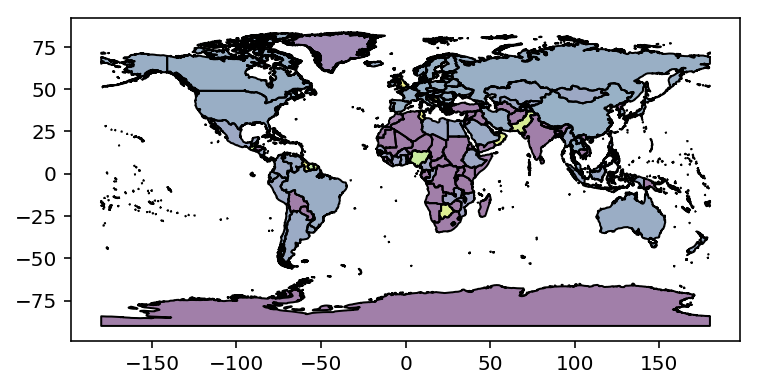

In [149]:
# gpd_countries.plot(column='frac_over_5')

In [193]:
pop_affine = population_tools.get_affine(pop_data)

In [194]:
from affine import Affine

In [195]:
pop_affine

Affine(0.066666666666667124, 0.0, 0.0,
       0.0, -0.066666666666662877, 85.000000000009194)

In [253]:
gpd_countries.geometry = gpd_countries.translate(xoff=180)

In [254]:
raster = features.rasterize(
    ((r.geometry, r.frac_over_5) for _, r in gpd_countries.iterrows()),
    out_shape=pop_data.population.shape[:2], 
    transform=pop_affine
              )

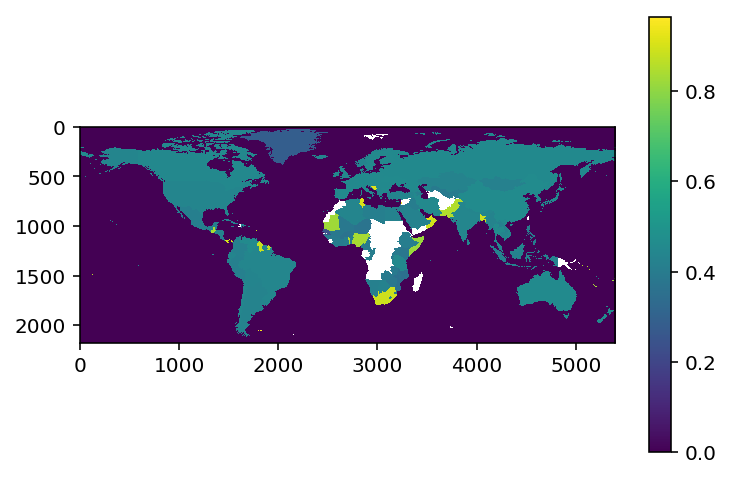

In [255]:
plt.imshow(raster, interpolation='nearest')
plt.colorbar()

In [228]:
from importlib import reload
reload(population_tools)

<module 'population_tools' from '/Users/jonathanchambers/Documents/UCL/Lancet/health-climate-exposure/population_tools.py'>

In [52]:
# Aborted attempt to index the population grid
# Looks like rasterising the countries shapes is going to work much better and be much faster
import rtree.index

lon, lat = np.meshgrid(pop_data.longitude[:10], pop_data.latitude[:10])

@jit
def build_index():
    idx = rtree.index.Index(str(DATA_SRC / 'lancet' / 'pop_file_index'))
    dims = lon.shape
    c = 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            lo = lon[i, j]
            la = lat[i, j]
            idx.insert(c, (lo, la), obj=(i, j))
            c += 1
    return idx
    